 <div style="text-align:center;">
  # <span style="color:green; font-size:larger; font-weight:bold;">Vérification de la loi d'Okun dans plusieurs pays du monde</span><br><br>
  <span style="font-weight:bold;">Présenté par:</span><br>
  <span>NOUBOUSSI GNINTEDEM LUCIE MARIMAR</span><br>
  <span>YOUSRA JEDDOUB</span> <br>
  <span>AMINA MANSEUR</span>
</div>


<span style="color:green; font-size:larger; font-weight:bold;">INTRODUCTION</span>

FAIRE UNE INTRODCUTION

# <span style="color:green">I- Importation et installation des packages</span>

In [ ]:
from importlib import reload
import declarations as d
reload(d)

# <span style="color:green; ">II- Construction de la base de données</span>

Il faut faire une explication de toutes les étapes que nous allons faire pour constituer notre base 

## <span style="color:green; text-align:center;">II-1 Importation de la base GemDataEXTR.Zip via son url de téléchargement</span>

In [ ]:
url = "https://datacatalogfiles.worldbank.org/ddh-published/0037798/DR0092042/GemDataEXTR.zip?"
d.load(url, "GemDataEXTR.zip")

In [ ]:
# Choix des fichiers à extraire

nom_fichiers = [('Unemployment Rate, seas. adj..xlsx', 'monthly'),
              ('GDP Deflator at Market Prices, LCU.xlsx', 'quarterly')
]

# Extraction des bases dans la mémoire: chomage et PIB déflaté
df_Unemployement, df_GDP = [d.extraire_fichier_zip('GemDataEXTR.zip', nom_fichier, nom_feuille)
                           for nom_fichier, nom_feuille in nom_fichiers]

L'extraction des données sur le taux de chômage et le PIB déflaté par pays est désormais complète. <br>
Dans la prochaine étape, nous procéderons à une exploration rapide de ces données et les fusionnerons pour une analyse plus approfondie.


### <span style="color:green; text-align:center;">II-1-1 Préparation des bases avant fusion</span>

#### <span style="color:green; text-align:center;">II-1-1-1 Base taux de chômage</span>

In [ ]:
# Visualisation
df_Unemployement.head()

In [ ]:
# Suppression des deux prmières lignes
df_Unemployement = df_Unemployement.iloc[2:].copy()

In [ ]:
# Type des données
df_Unemployement.info()


Le type de chaque variable est approprié et correspond aux types attendus.

##### Détection des doublons

In [ ]:
# Vérification des doublons
print("Nombre total de doublons dans df_Unemployement :",
      df_Unemployement[df_Unemployement.duplicated()].shape[0])

##### Correction des noms des pays

In [ ]:
# Appliquer la correction sur chaque colonne du DataFrame
df_Unemployement.columns = d.correct_country_name(df_Unemployement.columns)

# Listes des pays détecter
pays = d.detect_country_name(df_Unemployement.columns)

# Base avec colonnes corrigées
df_Unemployement = df_Unemployement[pays]

##### Détection des valeurs manquantes

In [ ]:
# Plot des valeurs manquantes
d.missing_plot(df_Unemployement)

Les données sont des séries temporelles.<br>
Grâce à la visualisation 2, on constate que pour la plupart des pays,<br>
les valeurs manquantes sont en début de la période considérée.<br>
Ainsi, nous allons garder les pays avec au moins 60% d'observations non manquantes.

In [ ]:
# Suppression des pays avec au moins 40% de valeurs manquantes sur la période
df_Unemployement = d.missing(df_Unemployement)

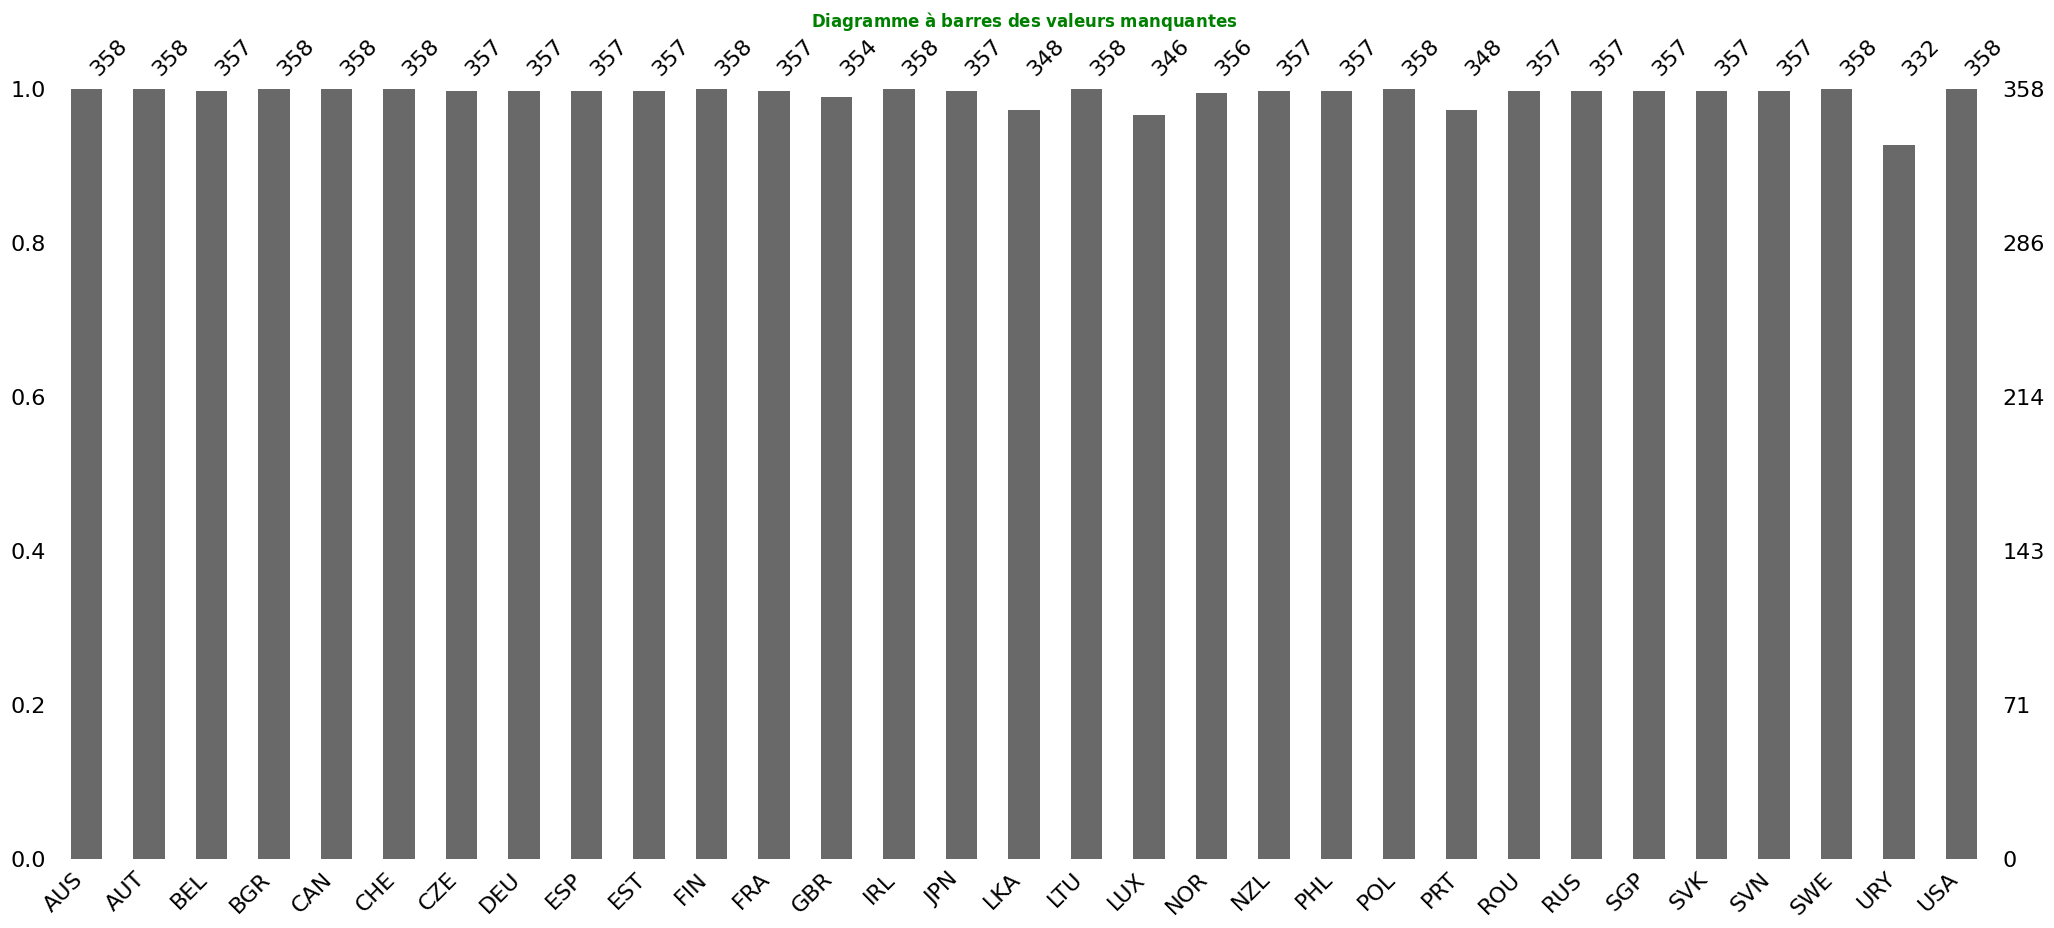

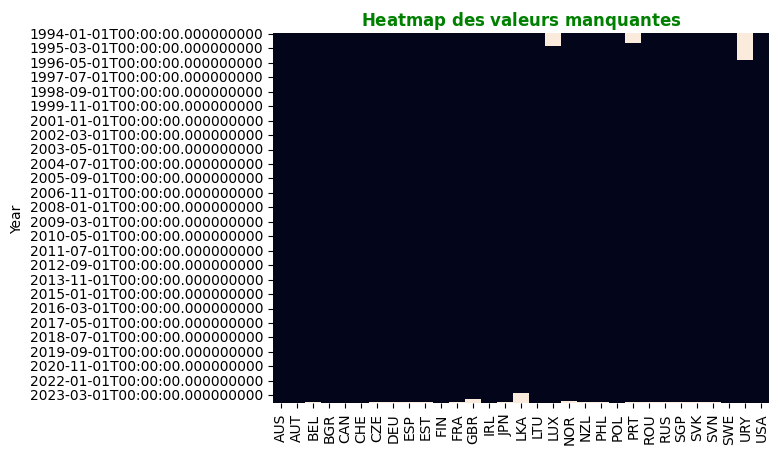

In [16]:
# Plot des valeurs manquantes
d.missing_plot(df_Unemployement)

##### Imputation des valeurs manquantes

In [17]:
# Imputation des valeurs manquantes 
df_Unemployement = d.fill_missing_with_median(df_Unemployement)

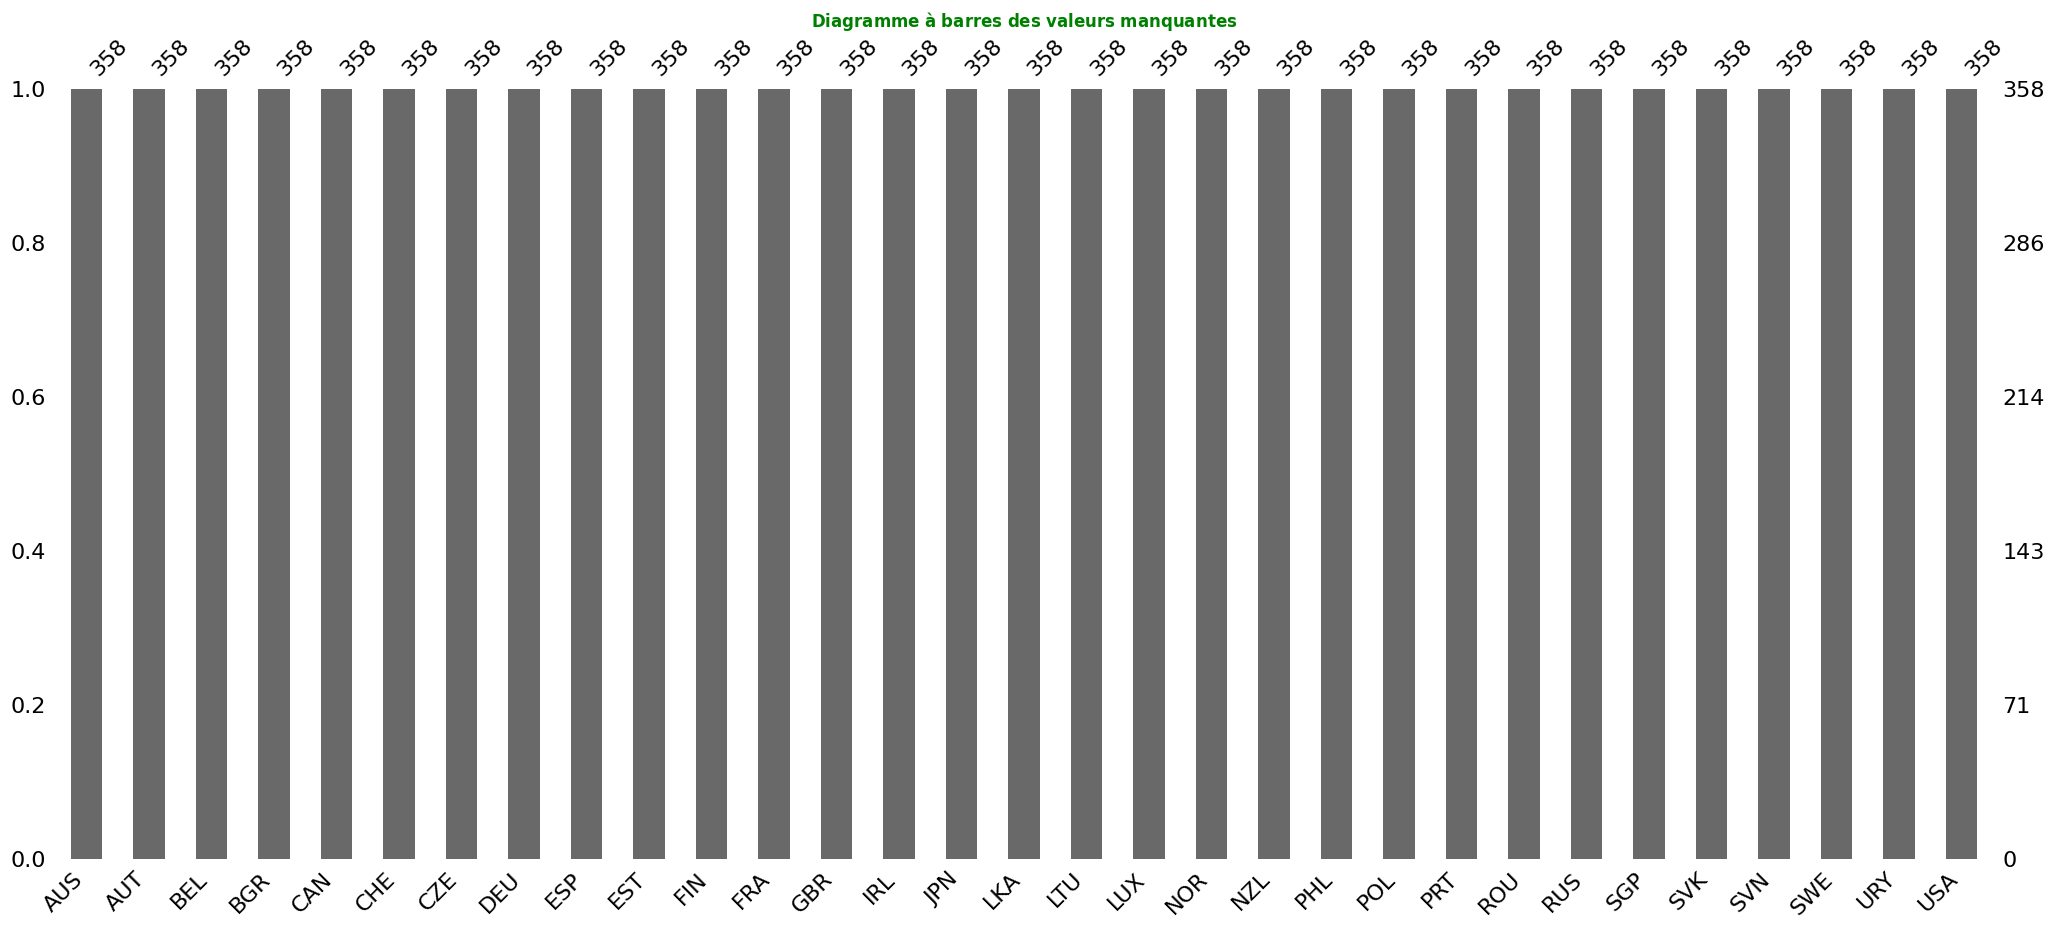

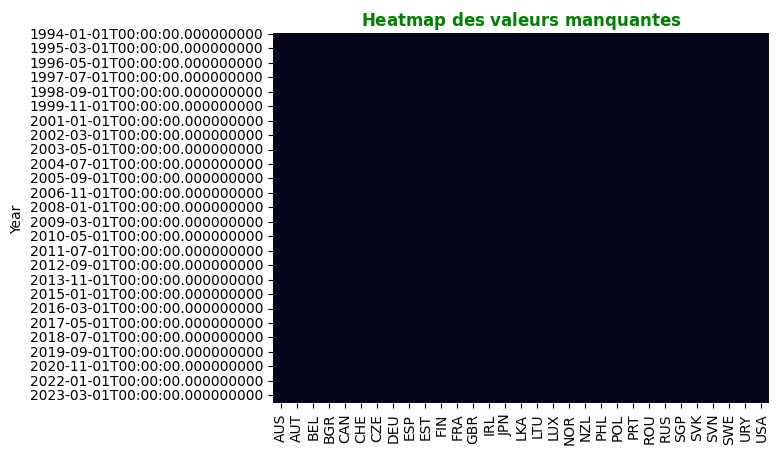

In [18]:
# Plot des valeurs manquantes
d.missing_plot(df_Unemployement)

In [19]:
# Colonnes présentes dans Uemploy
pays = df_Unemployement.columns
print(pays)

Index(['AUS', 'AUT', 'BEL', 'BGR', 'CAN', 'CHE', 'CZE', 'DEU', 'ESP', 'EST',
       'FIN', 'FRA', 'GBR', 'IRL', 'JPN', 'LKA', 'LTU', 'LUX', 'NOR', 'NZL',
       'PHL', 'POL', 'PRT', 'ROU', 'RUS', 'SGP', 'SVK', 'SVN', 'SWE', 'URY',
       'USA'],
      dtype='object')


In [24]:
# L'index de la DF
df_Unemployement.index
df_Unemployement.head(5)

,AUS,AUT,BEL,BGR,CAN,CHE,CZE,DEU,ESP,EST,...,POL,PRT,ROU,RUS,SGP,SVK,SVN,SWE,URY,USA
Year,,,,,,,,,,,,,,,,,,,,,
1994-Q1,9.814137,6.609708,9.641018,14.300000,10.700000,4.704339,4.300000,7.261003,22.000000,7.600000,...,16.450000,7.756329,10.900000,6.759498,1.750000,14.620000,14.650000,10.839335,12.100000,6.20
1994-Q2,10.269157,6.582263,9.728535,15.393333,10.866667,4.839299,4.200000,7.521107,22.233333,7.466667,...,16.533333,7.916827,10.900000,6.574419,1.666667,14.426667,14.966667,10.866990,12.083333,6.50
1994-Q3,9.745672,6.553856,9.881526,14.143333,10.366667,4.786481,4.266667,7.450542,22.166667,7.466667,...,16.666667,7.833934,11.033333,7.016574,1.666667,14.716667,14.566667,10.881637,11.900000,6.10
1994-Q4,9.409495,6.556515,9.778318,13.285000,10.150000,4.715754,4.400000,7.278648,22.000000,7.600000,...,16.650000,7.782301,11.050000,7.379864,1.800000,14.705000,14.350000,10.736920,11.900000,5.95
1995-Q1,8.833745,6.495949,9.696386,12.100000,9.550000,4.359326,4.200000,7.079487,21.375000,8.700000,...,15.775000,7.770154,10.500000,7.957235,1.750000,14.292500,14.025000,10.534358,11.837500,5.55


##### Transformation des données mensuelles en données trimestrielles

In [25]:
# Grouper par année et de 12 mois chacun
df_Unemployement = df_Unemployement\
    .groupby(df_Unemployement.index.Year)\
        .filter(lambda x: len(x) == 12)
df_Unemployement = d.pd.DataFrame(df_Unemployement)

# Transformation
df_Unemployement = df_Unemployement.resample('Q-JAN').mean()
# Ignorer les jours dans l'index
df_Unemployement.index = df_Unemployement.index.to_period('Q').strftime('%Y-Q%q')
# Appliquer le format trimestre au index
df_Unemployement.index = d.pd.to_datetime(df_Unemployement.index+ '-01', format='%Y-Q%m-%d')

# Formater l'index pour obtenir '1994-01' au lieu de '1994-01-01'
df_Unemployement.index = df_Unemployement.index.strftime('%Y-%m')


AttributeError: 'Index' object has no attribute 'Year'

#### <span style="color:green; text-align:center;">II-1-1-2 Base taux de croissance du PIB</span>

In [ ]:
# L'index de la DF
df_GDP.index

In [ ]:
# Formater l'index pour obtenir '1994-01' au lieu de '1994-01-01'
df_GDP.index = df_GDP.index.strftime('%Y-%m')
# Supprimez la ligne avec l'index NaN du DataFrame
df_GDP = df_GDP.drop(df_GDP.index[0])

In [ ]:
# Informations sur la DF (nombre de valeurs non nulles, type de données de chaque colonne...)
df_GDP.info()

##### Correction des noms des pays

In [ ]:
# Appliquer la correction sur chaque colonne du DataFrame
df_GDP.columns = d.correct_country_name(df_GDP.columns)

# Base avec colonnes corrigées presente dans Unemploy
df_GDP=df_GDP[pays]

##### Détection des doublons

In [ ]:
# Vérifier la présence de doublons
print("Nombre total de doublons dans df_GDP :", 
      df_GDP[df_GDP.duplicated()].shape[0])

In [ ]:
# Supprimer les doublons
df_GDP.drop_duplicates(inplace=True)

print("Nombre total de doublons dans df_GDP :", 
      df_GDP[df_GDP.duplicated()].shape[0])

##### Détection des valeurs manquantes

In [ ]:
# Plot des valeurs manquantes
d.missing_plot(df_GDP)

Les données sont des séries temporelles.<br>
Grâce à la visualisation 2, on constate que pour la plupart des pays,<br>
les valeurs manquantes sont en début de periode d'obervation d'observation.<br>
Ainsi, nous allons garder les pays avec au moins 60% des observations non manquantes.

In [ ]:
# Suppression des pays avec au moins 90% des valeurs manquantes sur la période
df_GDP = d.missing(df_GDP)

In [ ]:
# Plot des valeurs manquantes
d.missing_plot(df_GDP)

##### Imputation des valeurs manquantes

In [ ]:
# Correction des valeurs manquantes 
df_GDP = d.fill_missing_with_median(df_GDP)

In [ ]:
# Plot des valeurs manquantes
d.missing_plot(df_GDP)

In [ ]:
# Colonnes présentes dans gdp
pays1 = df_GDP.columns
# Colonnes non présentes dans unemploy et GDP
print(list(set(pays) - set(pays1))) 

### <span style="color:green; text-align:center;">II-1-2 Fusion des deux bases</span>

In [ ]:
reload(d)
## tranformation des basesen format long 
dfs = d.transform(df_Unemployement, 'Unemployment_rate')
dfs1 = d.transform(df_GDP, 'GDP_rate')
dfs1.head()

In [ ]:
# Fusion des bases

df_merge1 = d.pd.merge(dfs, dfs1, on=['YEAR', 'COUNTRY'], how='left')
df_merge1.head()

## <span style="color:green; text-align:center;">II-2 Importation de la base HNP_Stats_EXCEL.Zip via son url de téléchargement</span>

In [ ]:
url = "https://databank.worldbank.org/data/download/HNP_Stats_EXCEL.zip"
d.load(url,"HNP_Stats_EXCEL.zip")

In [ ]:
# Choix des fichiers à extraire
nom_fichiers = [('HNP_StatsEXCEL.xlsx', 'Data')]

# Extraction des bases dans la mémoire: chomage et PIB déflaté
Big_data = [d.extraire_fichier_zip('HNP_Stats_EXCEL.zip', nom_fichier, nom_feuille)
                           for nom_fichier, nom_feuille in nom_fichiers]

L'extraction des données sur le niveau d'éducation, l'espérance de vie, et le taux de croissance de la population. <br>
Dans la prochaine étape, nous procéderons à une exploration rapide de ces données et les fusionnerons pour une analyse plus approfondie.


### <span style="color:green; text-align:center;">II-2-1 Préparation des bases avant fusion</span>

In [ ]:
Big_data = Big_data[0]
Big_data.head()


Le type de chaque variable est approprié et correspond aux types attendus.

#### <span style="color:green; text-align:center;">II-2-1-1 Base espérance de vie</span>

In [ ]:
# Extraction des données sur l'espérance de vie 
df_LE = d.extract2(Big_data, 'expectancy','total')
df_LE.head(2)

In [ ]:
# Construction de la base life expentancy
reload(d)
df_LE = d.treat_info(df_LE, pays1)
df_LE.head(2)

##### Detections des valeurs manquantes

In [ ]:
# Plot des valeurs manquantes
d.missing_plot(df_LE)

print("Nombre total de valeurs manquantes est de ", 
      d.missing_plot(df_LE))

On n'observe aucune valeur manquante dans la base

#### <span style="color:green; text-align:center;">II-2-1-2 Base taux de croissance démographique</span>

In [ ]:
# Extraction des donnés sur la croissance démographique 
reload(d)
df_pop = d.extract2(Big_data, '^Population growth \(annual %\)$','')
df_pop.head(2)

In [ ]:
# Informations sur la DF (nombre de valeurs non nulles, type de données de chaque colonne...)
df_pop.info()

In [ ]:
# Construction de la base life expentancy
reload(d)
df_pop = d.treat_info(df_pop, country_codes)
df_pop.tail()

##### Détection des valeurs manquantes

In [ ]:
# Plot des valeurs manquantes
d.missing_plot(df_pop)

on observe aucune valeur manquantes dans la base

### <span style="color:green; text-align:center;">II-2-2 Fusion des deux bases</span>

In [ ]:
reload(d)
## Tranformation des bases en format long 
dfs = d.transform(df_LE, 'life_expentancy')
dfs1 = d.transform(df_pop, 'pop_growth_rate')
dfs.head()

In [ ]:
# Fusion des bases

df_merge2 = d.pd.merge(dfs, dfs1, on=['YEAR', 'COUNTRY'], how='left')
df_merge2.head()

In [ ]:
# Fusion merge1 et merge2.

df_merge3 = d.pd.merge(df_merge1, df_merge2, on=['YEAR', 'COUNTRY'], how='left')
df_merge3.head()

In [ ]:
# Enregistrez le DataFrame au format CSV
df_merge3.to_csv('final_data.csv', index=False)

## <span style="color:green; text-align:center;">II-3 Importation de la base Spatial Inequality Database via son url de téléchargement</span>

In [ ]:
url = "https://datacatalogfiles.worldbank.org/ddh-published/0064524/DR0091539/inequality%20GMD%20World%20Bank.xlsx?versionId=2023-05-22T17:13:22.2930786Z"
d.load(url,"inequality GMD World Bank.xlsx")

In [ ]:
df_SID = d.pd.read_excel("inequality GMD World Bank.xlsx",  sheet_name='data', index_col=0)
df_SID.head()

### <span style="color:green; text-align:center;">II-3-1 Préparation des bases avant fusion</span>

#### <span style="color:green; text-align:center;">II-3-1-1 base indice Theil</span>

In [ ]:
# Base de données de l'indice Theil
df_theil = df_SID.pivot(index='year', columns='countryname', values='index')
df_theil.head(5)

In [ ]:
df_theil = df_theil.drop(columns=df_theil.columns[0])
df_theil.info()

In [ ]:
#df_theil.columns

##### Corrections des noms des pays

In [ ]:
# Appliquer la correction sur chaque colonne du DataFrame
df_theil.columns = d.correct_country_name(df_theil.columns)

# base avec colonnes corrigées contenues dans les autres bases
#df_theil=df_theil[pays1]
#on a que 19 pays

In [ ]:
# Toutes les quatres bases à extraire ici
# La moyenne de l'indice de theil sur toutes les périodes
mean_theil = theil.mean(axis=0) 
# Base de données du taux d'urbanisation
urban = gmd.pivot(index='year', columns='countryname', values='sp_urb_totl_in_zs')
urban.head(5)
# La moyenne du taux d'urbanisation sur toutes les périodes
mean_urban = urban.mean(axis=0)
# Base de données du ratio de pauvreté
poverty = gmd.pivot(index='year', columns='countryname', values='si_pov_lmic')
poverty.head(5)
# La moyenne du ratio de pauvreté sur toutes les périodes
mean_poverty = poverty.mean(axis=0)

# IV- GMD  ici on a pas les meme années que faire ??

## 1.  Importation

In [ ]:
# Gini Mean Difference
gmd = pd.read_excel("C:/Users/yousr/Downloads/Projet_py/inequality GMD World Bank.xlsx",  sheet_name='data', index_col=0)
gmd.head(5)
col_names = gmd.columns
print(col_names)

## 2. Construction de la DF

### 2.1. Extraction des colonnes nécessaires

In [ ]:
# Base de données de l'indice Theil
theil = gmd.pivot(index='year', columns='countryname', values='index')
theil.head(5)

In [ ]:
# La moyenne de l'indice de theil sur toutes les périodes
mean_theil = theil.mean(axis=0) 

In [ ]:
# Base de données du taux d'urbanisation
urban = gmd.pivot(index='year', columns='countryname', values='sp_urb_totl_in_zs')
urban.head(5)

In [ ]:
# La moyenne du taux d'urbanisation sur toutes les périodes
mean_urban = urban.mean(axis=0)

In [ ]:
# Base de données du ratio de pauvreté
poverty = gmd.pivot(index='year', columns='countryname', values='si_pov_lmic')
poverty.head(5)

In [ ]:
# La moyenne du ratio de pauvreté sur toutes les périodes
mean_poverty = poverty.mean(axis=0)

In [ ]:
# Dans pandas, une Df à une colonne correspond à une série. On donne un nom à chaque série pour une éventuelle jointure
mean_poverty.name = 'Ratio de pauvreté'
mean_urban.name = "Taux urbanisation"
mean_theil.name = 'Theil'

## 2.2. Jointure 

In [ ]:
# Jointure entre df1 et df2 sur la colonne "countryname"
merged1 = pd.merge(mean_poverty, mean_urban, on='countryname', how='inner')
# Jointure entre le résultat précédent (merged_df) et df3 sur la colonne "countryname"
final_merged1 = pd.merge(merged1, mean_theil, on='countryname', how='inner')

In [ ]:
# Dans pandas, une Df à une colonne correspond à une série. On donne un nom à chaque série pour une éventuelle jointure
mean_LE.name = 'Espérance de vie'
mean_PGR.name = "Croissance démo"

In [ ]:
final_merged1.index.name = 'Country Name'  ####################################################################################
mean_LE.index.name = 'Country Name'
mean_PGR.index.name = 'Country Name'
merged_mean.index.name = 'Country Name'

In [ ]:
# Jointure entre df1 et df2 sur la colonne "countryname"
merged2 = pd.merge(final_merged1, mean_PGR, on='Country Name', how='inner')
# Jointure entre le résultat précédent (merged_df) et df3 sur la colonne "countryname"
merged3 = pd.merge(merged2, mean_LE, on='Country Name', how='inner')

# Transposé de merged3

In [ ]:
merged3_transpose = merged3.transpose()
col_names = merged3_transpose.columns
merged3_transpose.head(5)

# Code ISO des pays

In [ ]:
# Pour faciliter la lecture de la DF, on remplace les noms des pays par leurs codes ISO  correspondant

# Dictionnaire de correspondance entre noms complets des pays et leurs codes
corresp = {country.name: country.alpha_3 for country in pycountry.countries}

# Liste initiale des noms complets des colonnes
country = col_names
# Transformation des noms complets des colonnes en abréviations
country_codes = [corresp.get(pays, pays) for pays in country]

# Remplacement des noms des pays par leurs codes dans la merged
merged3_transpose.columns = country_codes
merged3_transpose.columns
merged3_transpose.head(5)

#Ordre alphabétique des colonnes 
merged3_transpose_sort = merged3_transpose.sort_index(axis=1)
merged3_transpose_sort.head(5)

In [ ]:
merged4 = merged3_transpose.transpose()
merged4.index.name = 'Country Name'
merged4.head(5)

In [ ]:
final_merged = pd.merge(merged4, merged_mean, on='Country Name', how='inner')